Available datasets:
	solidcubeanalysis.sh,
	AlloHollowCube_X1_7Nov22,
	AlloHollowCubeMin_X1_9Nov22,
	AlloPyramid_X3_17Nov22,
	AlloSolidCube_X1_7Nov22,
	Icosahedron_12vP_12vC_12Dec22,
	OffsetTestRingNoAllo,
	WTHollowCube_7Nov22,
	AlloPyramid_14Oct22,
	NoAlloPyramid_14Oct22,
	AlloSolidCube_X5_1_7Nov22,
	Icosahedron_12vP_12vC_21Dec22,
	AlloSolidCube_X5_4_7Nov22,
	AlloPyramid_Reduced_29Oct22,
	AlloSolidCube_X3_Singlet_7Nov22,
	WTSolidCube_7Nov22,
	Icosahedron_12vP_12vC_MSMethod_18Jan23


Input the name of a dataset:  AlloPyramid_14Oct22


Available datasets:
	solidcubeanalysis.sh,
	AlloHollowCube_X1_7Nov22,
	AlloHollowCubeMin_X1_9Nov22,
	AlloPyramid_X3_17Nov22,
	AlloSolidCube_X1_7Nov22,
	Icosahedron_12vP_12vC_12Dec22,
	OffsetTestRingNoAllo,
	WTHollowCube_7Nov22,
	AlloPyramid_14Oct22,
	NoAlloPyramid_14Oct22,
	AlloSolidCube_X5_1_7Nov22,
	Icosahedron_12vP_12vC_21Dec22,
	AlloSolidCube_X5_4_7Nov22,
	AlloPyramid_Reduced_29Oct22,
	AlloSolidCube_X3_Singlet_7Nov22,
	WTSolidCube_7Nov22,
	Icosahedron_12vP_12vC_MSMethod_18Jan23


Input the name of an analysis target (pyramid):  pyramid


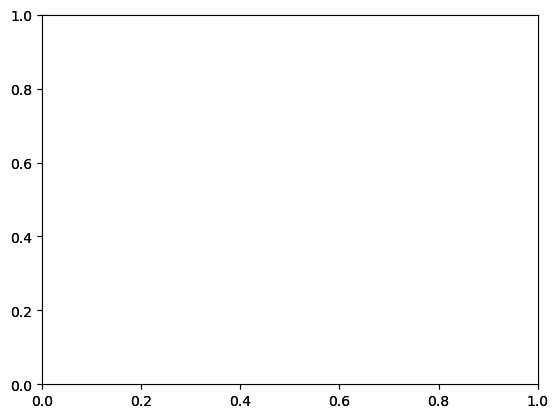

In [1]:
from input_output import *
print("Available datasets:\n\t" + ',\n\t'.join(os.listdir(sims_root())))
results_name = input("Input the name of a dataset: ")
# construct a PatchySimResultSet object from the specified directory
results = choose_results(results_name)
target_name = input(f"Input the name of an analysis target ({','.join(results.targets.keys())}): ")

target = results.targets[target_name]

In [ ]:
# narrow type = set of parameters specifying bonding angles between patches
nt = int(input(f"Input the narrow type of the data ({', '.join([f'{nt}' for nt in results.narrow_types()])}): "))
# cutoff = the lower limit for counting clusters as partially assembled forms of the target
# cutoff = 1 -> only count fully assembled clusters
cutoff = float(input("Input the graph match cutoff: "))
relative = input("Calculate relative yields?") == "True"
overreach = input("Include overreaching graphs in yield calculations?") == "True"
rs = input("Enter resample frequency (in kilosteps, should be >= to the observable print interval):")

In [ ]:
df = results.calculateYields(target_name, cutoff, overreach)

In [ ]:
# resample yields program
picklename = results.root_dir + os.sep + f"target_{target_name}_rs{rs}_cutoff{cutoff}_over{overreach}_rel{relative}.pickle"
if os.path.isfile(picklename):
    df = pd.read_pickle(picklename)
else:
    gb = df.groupby(['shape', "temp", "potential"])
    resampling = gb.resample(rule=f'{rs}us', on='time')
    df = resampling.mean()
    df.drop(labels=['duplicate', 'temp', 'potential'], axis='columns', inplace=True)
    df['yield_min'] = resampling.min()['yield']
    df['yield_max'] = resampling.max()['yield']
    df['yield_stdev'] = resampling.std()['yield']
    df.reset_index(inplace=True)
    df['time'] = pd.to_numeric(df['time'].dt.microseconds)
    df.to_pickle(picklename)

In [ ]:
df = df[df['potential'] == nt]

In [ ]:
# data = []
# for run_result in results.flat_runs():
#     data += results.annanosecondsalyseClusterYield(run_result, target=target_name)
# df = pd.DataFrame(data)
# # df['time'] /= 10e6 # to make data more readable

rule_data = pd.DataFrame(
    [
        {
            'run_name': results.runs[int(i / len(results.rule))].name,
            'cube_name': results.rule[i % len(results.rule)].name,
            'level': lvl
        }
        for i, lvl in enumerate(itertools.chain.from_iterable([r.cube_type_levels for r in results.runs]))
    ]
)



In [ ]:
# df.set_index(['time','shape','temp','potential','duplicate'], inplace=True)

max_time = df['time'].max()
max_yield = df['yield'].max()

In [ ]:
yield_data = [df[df['temp'].copy() == t] for t in df['temp'].unique()]

In [ ]:
if (relative):
    for t, yld in zip(results.temperatures(), yield_data):
        yld['yield'] = yld['yield'] / (yld['num_assemblies'] * target['rel_count'])
    ymax = 1.0
else:
    if (df['num_assemblies'].unique().size > 1):
        print ("Assembly counts are not consistant, scaling may be wonky. You may want to do a relative yield analysis.")
    ymax = df['num_assemblies'].max() * target['rel_count']

In [ ]:
charts = []
for i, yld in enumerate(yield_data):
    charts.append(alt.Chart(yld, title="Assembly Yields at T=%f" % results.temperatures()[i]))
    charts[i] = charts[i].mark_line().encode(
            x=alt.X('time:Q', title="Time (megasteps)", axis=alt.Axis(tickCount=5)),
            y=alt.Y(
                "yield:Q",
                title="Yield",
                scale=alt.Scale(
                    domain=(0, ymax)
                )
            ),
            color=alt.Color('shape', scale=alt.Scale(scheme="accent"), title="Configuration")
    )
    charts[i] = charts[i].properties(width=int(800 / len(results.temperatures())), height=250)
    errbars = charts[i].mark_area(opacity=0.25).encode(
        x=alt.X("time:Q", axis=alt.Axis(tickCount=5)),
        y="yield_min:Q",
        y2="yield_max:Q"
    )
    charts[i] = charts[i] + errbars
        
chart = alt.hconcat(
    alt.Chart(rule_data).mark_bar().encode(
        x=alt.X('run_name', title="Configuration"),
        y=alt.Y('level', title="Level"),
        color=alt.Color('cube_name', title="Type")
    ),
    *charts
)

# ) + alt.Chart(df).mark_errorband(extent='ci', opacity=0.2).encode(
#     x=alt.X('time:Q'),
#     y=alt.Y('yield', title='Yield'),
#     color = alt.Color('shape', scale=alt.Scale())
# )).properties(width=600, height=450).facet(column='potential', row='type').properties(title=sim_name)

chart.properties(title=f"{results.export_name} - {target_name} - NT{nt}")
# chart.save(sims_root() + os.sep + results.export_name + os.sep + results.export_name + ".html")